## This notebook does slew simulations, and check all aos components (M1M3, M2, hexapods) behavior during the slew-and-track process

This is expected to work both for SUMMIT and NCSA

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import MTHexapod

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

<Figure size 432x288 with 0 Axes>

In [5]:
#summit = 1 #use this for summit testing
summit = 0 #use this for NCSA

In [6]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/ts_ddsconfig/config/ospl-shmem.xml
ncsa
0


In [7]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

In [ ]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

In [ ]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

In [ ]:
await mtcs.start_task

In [ ]:
mtcs.components_attr

In [ ]:
ptg = mtcs.rem.mtptg
mount = mtcs.rem.mtmount
rot = mtcs.rem.mtrotator
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
#aos = mtcs.rem.mtaos

### Check that all components are ready

In [ ]:
await checkAOSCompStates(m1m3, m2, camhex, m2hex)

In [ ]:
await checkSlewCompStates(ptg, mount, rot)

In [ ]:
#await salobj.set_summary_state(mount, salobj.State.STANDBY)

In [ ]:
await readyM1M3(m1m3)

In [ ]:
await readyM2(m2)

In [ ]:
await readyHexForAOS(camhex)

In [ ]:
await readyHexForAOS(m2hex)

In [ ]:
end = Time(datetime.now(), scale='tai')
start = end - timedelta(seconds=1000)
df = await client.select_time_series('lsst.sal.ESS.temperature8Ch', '*', start, end, csc_index)
if len(df)>0:
    fig, ax = plt.subplots(1,1, figsize=(15,4))
    for i in range(8):
        plt.plot(getattr(df, 'temperatureC%02d'%i))
    plt.grid()
else:
    print('No temperature data on the camera hexapod in the past 1000s.')

### Do a few slews

In [ ]:
#comment and uncomment the below depending on which components are expected to be on
#by default, MTCS checks on every component (during the slew).
mtcs.check.mtaos = False
mtcs.check.mtm1m3 = True
mtcs.check.mtm2 = True
mtcs.check.mthexapod_1 = True
mtcs.check.mthexapod_2 = True
mtcs.check.mtdome = False
mtcs.check.mtdometrajectory = False

#### Do 4 slews, then stop tracking

In [ ]:
dec = -34.
for j in range(2):
    time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
    ra = time_and_date.lst + 0.5
    for i in range(2):
        
        aa = await mount.tel_elevation.aget()
        current_el = aa.actualPosition
        
        obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 1.) #with 1s delay
        azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
        target_el = azel.alt.value
        
        print('moving from elevation %.1f deg to %.1f deg'%(current_el, target_el))
        await moveMountConstantV(mount, current_el, target_el)
        print('start a slew')
        await mtcs.slew_icrs(ra=ra, dec=dec, rot=0., rot_type=RotType.PhysicalSky)
        await asyncio.sleep(39.)
        ra -= 3.5/15.0

await ptg.cmd_stopTracking.set_start(timeout=5.)

#### Plot the above process

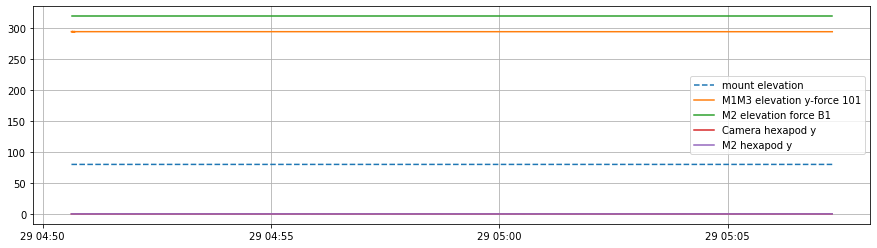

In [10]:
end = Time(datetime.now(), scale='tai')
start = end - timedelta(seconds=1000)

dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedElevationForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.application', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(dfm.actualPosition, '--', label='mount elevation')
plt.plot(dfm1m3.yForces0, label='M1M3 elevation y-force 101')
plt.plot(dfm2.lutGravity0, label='M2 elevation force B1')
plt.plot(dfh1.position1, label='Camera hexapod y')
plt.plot(dfh2.position1, label='M2 hexapod y')
plt.grid()
plt.legend()

#### Check if the telescope is in tracking mode. If yes, need to stop stacking.

The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

#### Close up. Put all simulators to standby

In [ ]:
await salobj.set_summary_state(ptg, salobj.State.STANDBY)

In [ ]:
await salobj.set_summary_state(rot, salobj.State.STANDBY)

In [ ]:
await salobj.set_summary_state(mount, salobj.State.STANDBY)